In [1]:
import sys
sys.path.insert(1, '/home/alex/Documents/Research/PEnGUIn/read/Analysis')

In [2]:
from read_penguin import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import geometry as geo
from Interpolate import *
from Search import binSearch
import transform as tr
import time

In [3]:
def RK45(y0, xi, xf, maxstep, maxerror, fun):
    h = maxstep
    x = xi
    while(True):
        #Calculating k's
        k1 = h*fun(x, y0)
        k2 = h*fun(x+h/4, y0+k1/4)
        k3 = h*fun(x+3*h/8, y0+3*k1/32+9*k2/32)
        k4 = h*fun(x+12*h/13, y0+1932*k1/2197 - 7200*k2/2197 + 7296*k3/2197)
        k5 = h*fun(x+h, y0 + 439.0*k1/216.0 - 8.0*k2 + 3680*k3/513.0 - 845.0*k4/4104.0)
        k6 = h*fun(x+h/2, y0 - 8.0*k1/27.0 + 2.0*k2 - 3544.0*k3/2565.0 + 1859.0*k4/4104.0 - 11.0*k5/40.0)

        #Calculating 5th order approximation and estimated error
        fourth = (25.0*k1/216.0 + 1408*k3/2565.0 + 2197.0*k4/4104.0 - k5/5.0)
        fifth = (16.0*k1/135.0 + 6656.0*k3/12825.0 + 28561.0*k4/56430.0 - 9.0*k5/50.0 + 2.0*k6/55.0)

        error = (fourth - fifth)/h
        for l in range(len(error)):
            if(error[l] < 0):
                error[l] = -error[l]

        #Finding relative error and adapting step size
        estError = 0
        for i in range(len(error)):
            estError += pow(error[i], 2)
        estError = estError**(1/2)

        if(estError > maxerror):
            h = h*0.9*pow(maxerror/estError, 0.2)
            continue

        if(estError <= maxerror):
            hnew = 1.1*h
            if(h > maxstep):
                hnew = maxstep
            break
    return [fifth, error, h, hnew]

In [4]:
#Loading 3D Data
xres3d = 384
yres3d = 768
zres3d = 216
data3d = load_3D_data("/home/alex/Documents/Research/PEnGUIn/", xres3d, yres3d, zres3d, "h50_1p1J_e0_PPM4", 0)

In [5]:
def isoVel3D(x, y):
    xVals = cell_center(data3d[1])
    yVals = cell_center(data3d[2])
    zVals = cell_center(data3d[3])
    xVel = data3d[6]
    yVel = data3d[7]
    zVel = data3d[8]
    y = geo.cartesianToSpherical(y, dim = 3)
    print(y)
    x1 = y[0] #X Position
    x2 = y[1] #Y Position
    if(x2 < 0):
        x2 = x2%(2*np.pi) + 2*np.pi
    x3 = y[2] #Z Position
    
    xPoints = binSearch(xVals, 0, len(xVals), x1)
    yPoints = binSearch(yVals, 0, len(yVals), x2)
    zPoints = binSearch(zVals, 0, len(zVals), x3)
    if(xPoints[0] == -np.infty):
        return np.array([0,0,0])
    elif(xPoints[1] == np.infty):
        return np.array([0,0,0])
    if(yPoints[0] == -np.infty):
        yPoints = (len(yVals)-1, 0)
    elif(yPoints[1] == np.infty):
        yPoints = (0, len(yVals)-1)
    if(zPoints[1] == np.infty):
        if x3 > np.pi/2:
            return np.array([0,0,0])
        else:
            zPoints = (-1, -2)
    if(zPoints[0] == -np.infty):
        return np.array([0,0,0])
        
    lowx = xPoints[0]
    highx = xPoints[1]
    lowy = yPoints[0]
    highy = yPoints[1]
    lowz = zPoints[0]
    highz = zPoints[1]
    
    targetCoords = (x1,x2,x3)
    minCoords = (xVals[lowx], yVals[lowy], zVals[lowz])
    maxCoords = (xVals[highx], yVals[highy], zVals[lowz])
    
    xcubeVals = [xVel[lowz,lowy,lowx], xVel[highz,lowy,lowx], xVel[lowz,highy,lowx], xVel[highz,highy,lowx], xVel[lowz,lowy,highx], xVel[highz, lowy, highx], xVel[lowz, highy, highx], xVel[highz, highy, highx]]
    vx = triInterpolate(targetCoords, xcubeVals, minCoords, maxCoords)
    ycubeVals = [yVel[lowz,lowy,lowx], yVel[highz,lowy,lowx], yVel[lowz,highy,lowx], yVel[highz,highy,lowx], yVel[lowz,lowy,highx], yVel[highz, lowy, highx], yVel[lowz, highy, highx], yVel[highz, highy, highx]]
    vy = triInterpolate(targetCoords, ycubeVals, minCoords, maxCoords)
    zcubeVals = [zVel[lowz,lowy,lowx], zVel[highz,lowy,lowx], zVel[lowz,highy,lowx], zVel[highz,highy,lowx], zVel[lowz,lowy,highx], zVel[highz, lowy, highx], zVel[lowz, highy, highx], zVel[highz, highy, highx]]
    vz = triInterpolate(targetCoords, zcubeVals, minCoords, maxCoords)
    v = np.array([vx, vy, vz])
    return np.array(geo.sphericalToCartesianVelocity(y, v, dim = 3))

In [6]:
def flowLine3D(xi, yi, zi, Xs, Ys, Zs, maxerror, fun, maxstep):
    vals = []
    xs = []
    ys = []
    y0 = np.array([xi, yi, zi])
    xf = np.max(np.abs(Xs))
    yf = np.max(np.abs(Ys))
    zf = np.max(np.abs(Zs))
    h = abs(xf-xi)/10000
    vals.append(zi)
    xs.append(xi)
    ys.append(yi)
    n = 0
    aveCellX = abs(xf - xi)/len(Xs)
    aveCellY = abs(yf - yi)/len(Ys)
    aveCellZ = abs(zf - zi)/len(Zs)
    correction = RK45(y0, y0[0], xf, h, maxerror, fun)
        
    y0 = y0 + correction[0]
    vals.append(y0[2])
    xs.append(y0[0])
    ys.append(y0[1])
    h = correction[3]
    if(h > maxstep):
        h = maxstep
    '''while(abs(y0[0]) <= abs(xf) and abs(y0[1]) <= abs(yf) and abs(y0[2]) <= abs(zf) and n < 1000):
        correction = RK45(y0, y0[0], xf, h, maxerror, fun)
        if(abs(correction[0][0]) <= 0.001*aveCellX and abs(correction[0][1]) <= 0.001*aveCellY and abs(correction[0][2]) <= 0.001*aveCellZ):
            break
        y0 = y0 + correction[0]
        vals.append(y0[2])
        xs.append(y0[0])
        ys.append(y0[1])
        h = correction[3]
        if(h > maxstep):
            h = maxstep
        n = n+1'''

    y0 = np.array([xi, yi, zi])
    h = abs(xf-xi)
    n = 0
    '''while(abs(y0[0]) <= abs(xf) and abs(y0[1]) <= abs(yf) and abs(y0[2]) <= abs(zf) and n < 1000):
        correction = RK45(y0, y0[0], xf, h, maxerror, fun)
        print(correction[0])
        if(abs(correction[0][0]) <= 0.001*aveCellX and abs(correction[0][1]) <= 0.001*aveCellY and abs(correction[0][2]) <= 0.001*aveCellZ):
            break
        y0 = y0 - correction[0]
        vals.insert(0, y0[2])
        xs.insert(0, y0[0])
        ys.insert(0, y0[1])
        h = correction[3]
        if(h > maxstep):
            h = maxstep
        n = n+1'''
    return (xs, ys, vals)

In [7]:
'''for i in range(xres3d):
    for j in range(yres3d):
        for k in range(zres3d):
            data3d[7][k,j,i] = data3d[7][k,j,i] - data3d[1][i]*np.sin(data3d[3][k])'''
            
coordX = np.array([-1.1 + 2.2*i/1000 for i in range(1000)])
coordY = np.array([-1.1 + 2.2*i/1000 for i in range(1000)])
coordZ = np.array([-0.1 + 0.2*i/1000 for i in range(1000)])

(1.1, 3.141592653589793, 1.5707963267948966)
(1.100000005604411, 3.1416448642186197, 1.5708827205925378)
(1.1000000007881203, 3.141612232575618, 1.5708287244691193)
(1.100000069343231, 3.1417763057224297, 1.5711002190292749)
(1.1000003704003778, 3.1420171066397797, 1.5714986761959637)
(1.1000000078723138, 3.1415307743260215, 1.5706939341460002)
(1.1, 3.141592653589793, 1.5707963267948966)
(1.1000000000079053, 3.1415946144889357, 1.5707995715273975)
(1.1000000000011119, 3.141593388926972, 1.5707975435695845)
(1.1000000000978132, 3.1415995510993864, 1.5708077402190048)
(1.1000000005224735, 3.141608594973565, 1.5708227052683672)
(1.1000000000111045, 3.1415903295611796, 1.5707924811860066)
(1.1, 3.141592653589793, 1.5707963267948966)
(1.1000000000000112, 3.1415927272355755, 1.5707964486578005)
(1.1000000000000016, 3.1415926812069612, 1.5707963724934857)
(1.100000000000138, 3.1415929126405926, 1.5707967554505735)
(1.100000000000737, 3.1415932523027283, 1.5707973174951717)
(1.100000000000015

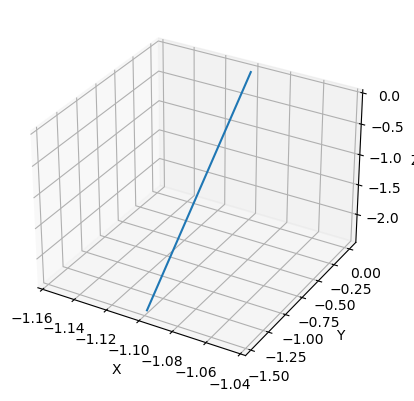

In [8]:
flow = flowLine3D(-1.1,0,0,coordX,coordY,coordZ, 1e-8, isoVel3D,0.1)
ax = plt.figure().add_subplot(projection='3d')
ax.plot(flow[0], flow[1], flow[2])
'''flow = flowLine3D(1.1,np.pi,0.98*np.pi/2,data3d[1],data3d[2],data3d[3], 1e-8, isoVel3D,2*np.pi)
ax.plot(flow[0], flow[1], flow[2])
flow = flowLine3D(1.1,np.pi,0.97*np.pi/2,data3d[1],data3d[2],data3d[3], 1e-8, isoVel3D,2*np.pi)
ax.plot(flow[0], flow[1], flow[2])
flow = flowLine3D(1.1,np.pi,0.96*np.pi/2,data3d[1],data3d[2],data3d[3], 1e-8, isoVel3D,2*np.pi)
ax.plot(flow[0], flow[1], flow[2])
flow = flowLine3D(1.1,np.pi,0.95*np.pi/2,data3d[1],data3d[2],data3d[3], 1e-8, isoVel3D,2*np.pi)
ax.plot(flow[0], flow[1], flow[2])'''
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()